In [1]:
import tensorflow as tf
import deepxde as dde
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from pykrige.ok import OrdinaryKriging
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import norm, lognorm
import xarray as xr
from sklearn.preprocessing import StandardScaler
import geopandas as gpd
import requests
from bs4 import BeautifulSoup
import pandas as pd

dde.config.set_default_float("float32")

import warnings

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.



Instructions for updating:
non-resource variables are not supported in the long term
Set the default float type to float32


In [2]:
import warnings

warnings.filterwarnings("ignore")
# Configurazioni e percorsi
# Configurazioni e percorsi
FIGURE_PATH = "C:/Users/vitas/Desktop/LE PINN/pinn.global.dust/pinn.global.dust/Code/figures/"
DATA_PATH = "C:/Users/vitas/Desktop/LE PINN/pinn.global.dust/pinn.global.dust/Data/"
DATA_LOAD_PATH = DATA_PATH + "original_data/"
INPUT_MODEL_PATH = DATA_PATH + "processed_data/"
MODEL_SAVE_PATH = DATA_PATH + "trained_models/"
RESULTS_PATH = DATA_PATH + "model_results/"
path_to_shapefile = "C:/Users/vitas/Desktop/LE PINN/pinn.global.dust/pinn.global.dust/ne_110m_admin_0_countries.shp"
world = gpd.read_file(path_to_shapefile)

In [3]:
with open("functions_training_model.py", 'r') as file:
    content = file.read()

# Execute the content of the .py file
exec(content)
df_simulated_Holocene = pd.read_csv(INPUT_MODEL_PATH + "df_simulation_Holocene.csv")
#df_global_grid = pd.read_csv(INPUT_MODEL_PATH + "df_global_grid.csv")

df_wind = pd.read_csv(INPUT_MODEL_PATH + "df_wind.csv", usecols=['wind', 'latitude'])

latitude_wind, mean_wind = df_wind['latitude'].values / 90, df_wind['wind'].values / df_wind['wind'].max()


def wind_latitude(latitude):
    interpolated = wind_tf_interp(latitude, tf.convert_to_tensor(latitude_wind), tf.convert_to_tensor(mean_wind))
    return interpolated


tf_wind_latitude = tf.function(wind_latitude)


In [4]:
# creo una griglia 1°x1°
# Definisci i range
lon_vals = np.arange(-180, 180, 1)  # Include 180
lat_vals = np.arange(-90, 90, 1)    # Include 90

# Crea la griglia con tutti i punti (lon, lat)
lon_grid, lat_grid = np.meshgrid(lon_vals, lat_vals)
lon_flat = lon_grid.flatten()
lat_flat = lat_grid.flatten()

# Crea il DataFrame
df_global_grid_1x1 = pd.DataFrame({
    'lon': lon_flat,
    'lat': lat_flat
})

print(f"Griglia creata con {len(df_global_grid_1x1)} punti")

# Opzionale: salva su CSV
 #df_global_grid_1x1.to_csv("global_grid_1x1.csv", index=False)


Griglia creata con 64800 punti


In [5]:
def training_points(df):
    data_observ_points = dde.data.DataSet(
        X_train=df[['lon', 'lat']].values / 90,
        y_train=df['log_dep_norm'].values.reshape(-1, 1),
        X_test=df[['lon', 'lat']].values / 90,
        y_test=df['log_dep_norm'].values.reshape(-1, 1),
        standardize=False)

    observe_u = dde.icbc.PointSetBC(data_observ_points.train_x,
                                    df['log_dep_norm'].values.reshape(-1, 1), component=0)

    return data_observ_points, observe_u


x_min, x_max = -2.0, 2.0
y_min, y_max = -0.89, 0.89

left_corner = np.array([x_min, y_min])  # xmin, ymin – Coordinate of bottom left corner.
right_corner = np.array([x_max, y_max])  # xmax, ymax – Coordinate of top right corner.
geometry_rectangle = dde.geometry.geometry_2d.Rectangle(left_corner, right_corner)

# Reduce the training domain to avoid pole singularities.
df_simulated_Holocene_2 = df_simulated_Holocene[
    (df_simulated_Holocene['lat'] >= -81) & (df_simulated_Holocene['lat'] <= 81)]


def pde(x, u):
    du_x = dde.grad.jacobian(u, x, j=0)  # du/dlambda
    du_y = dde.grad.jacobian(u, x, j=1)  # du/dtheta

    K = wind_latitude(x[:, 1:2])
    K = tf.cast(K, tf.float32)

    du_xx = dde.grad.hessian(u, x, i=0, j=0)  # d^2u/dlambda^2
    du_yy = dde.grad.hessian(u, x, i=1, j=1)  # d^2u/dtheta^2

    return (
        (-K * du_x * (1 / tf.cos(x[:, 1:2] * np.pi / 2)) + D * (
            (1 / (tf.cos(x[:, 1:2] * np.pi / 2) ** 2) * du_xx + du_yy - tf.tan(x[:, 1:2] * np.pi / 2) * du_y)))
    )


def space_boundary_north(x, on_boundary):
    return on_boundary and np.isclose(y_max, x[1])


def space_boundary_south(x, on_boundary):
    return on_boundary and np.isclose(y_min, x[1])


def periodic_boundary(x, domain):
    return domain and (np.isclose(x[0], x_min) or np.isclose(x[0], x_max))

In [6]:
def train_process(data_observ_points, observe_u, D, bc_1, bc_2, model_name):
    data = dde.data.PDE(
        geometry_rectangle,
        pde,
        [observe_u, periodic_condition, periodic_condition_derivative, bc_1, bc_2],
        num_domain=2592,
        num_boundary=216,
        anchors=data_observ_points.train_x,
        train_distribution='uniform'
    )

    neurons = 64
    layer = 6
    layer_size = [2] + [neurons] * layer + [1]
    activation = "selu"
    initializer = "Glorot normal"
    net = dde.maps.FNN(layer_size, activation, initializer)
    model = dde.Model(data, net)
    dde.optimizers.set_LBFGS_options(maxcor=50, ftol=1e-20, maxiter=1e5)
    model.compile("adam", lr=0.00001, external_trainable_variables=[D, north_mean, south_mean],
                  loss_weights=[1, 10, 0.5, 0.5, 1, 1])

    # Train and save the model
    import os
    os.makedirs(MODEL_SAVE_PATH + model_name, exist_ok=True)

    checkpointer = dde.callbacks.ModelCheckpoint(
        f"{MODEL_SAVE_PATH}{model_name}/{model_name}.ckpt",
        verbose=0, period=10000,
    )

    variable = dde.callbacks.VariableValue([D, north_mean, south_mean], period=10000,
                                           filename=MODEL_SAVE_PATH + model_name + "/variables.dat")

    losshistory, train_state = model.train(epochs=15000, callbacks=[variable, checkpointer])
    dde.saveplot(losshistory, train_state, issave=False, isplot=True)
    params = variable.get_value()

    return model, params, train_state.best_step, losshistory


north_mean = dde.Variable(-1.0)
south_mean = dde.Variable(-2.0)
D = dde.Variable(1.0)

bc_1 = dde.DirichletBC(geometry_rectangle, lambda x: north_mean, space_boundary_north)
bc_2 = dde.DirichletBC(geometry_rectangle, lambda x: south_mean, space_boundary_south)

periodic_condition = dde.icbc.PeriodicBC(geom=geometry_rectangle, component_x=0, on_boundary=periodic_boundary,
                                         derivative_order=0)
periodic_condition_derivative = dde.icbc.PeriodicBC(geom=geometry_rectangle, component_x=0,
                                                    on_boundary=periodic_boundary, derivative_order=1)


In [7]:


# Numero di strisce in cui dividere la regione
n_strisce = 18

# Estremi latitudinali della regione
lat_min, lat_max = -90, 90
lon_min, lon_max = -180, 180
# Calcolo gli estremi delle strisce (n_strisce+1 punti di divisione)
lon_bands = np.linspace(lon_min, lon_max, n_strisce + 1)

print("Limiti delle strisce longitudinali:", lon_bands)



Limiti delle strisce longitudinali: [-180. -160. -140. -120. -100.  -80.  -60.  -40.  -20.    0.   20.   40.
   60.   80.  100.  120.  140.  160.  180.]


In [8]:
def assign_band(lon):
    for i in range(n_strisce):
        if lon_bands[i] <= lon < lon_bands[i + 1]:
            return i
    if lon == lon_bands[-1]:
        return n_strisce - 1

# Assegna la striscia a ogni punto
df_simulated_Holocene_2['lon_band'] = df_simulated_Holocene_2['lon'].apply(assign_band)

In [9]:
train_bands = [0, 1, 3, 4,  5, 7, 8, 9, 11 , 12, 13, 15 , 16 ,17 ]
test_bands = [ 2, 6, 10,  14]

df_train = df_simulated_Holocene_2[df_simulated_Holocene_2['lon_band'].isin(train_bands)]
df_test = df_simulated_Holocene_2[df_simulated_Holocene_2['lon_band'].isin(test_bands)]

print(f"Punti train: {len(df_train)}, punti test: {len(df_test)}")


Punti train: 38528, punti test: 11008


In [ ]:
# Seleziona 200 punti casuali per ogni banda nel DataFrame df_train
df_train_subset = (
    df_train.groupby("lon_band", group_keys=False)
    .apply(lambda x: x.sample(n=200, random_state=42))
    .reset_index(drop=True)
)

data_obs, bc_point = training_points(df_train_subset)
pinn_model, _, _,losshistory = train_process(data_obs, bc_point, D, bc_1, bc_2, 'model_region')
Xg = (df_test[['lon', 'lat']].values / 90.0).astype(np.float32)
Yg = df_test['log_dep_norm'].values.reshape(-1, 1).astype(np.float32)
pinn_g = pinn_model.predict(Xg)
mse_pinn = np.mean((pinn_g - Yg) ** 2)
print(f"PINN MSE sulla regione: {mse_pinn:.4f}")



Compiling model...
Building feed-forward neural network...
'build' took 0.159326 s


'compile' took 2.125356 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [6.78e+01, 3.79e+01, 9.74e+00, 1.83e-02, 3.61e+00, 4.91e+00]    [6.78e+01, 3.79e+01, 9.74e+00, 1.83e-02, 3.61e+00, 4.91e+00]    []  
1000      [1.72e+00, 6.03e+00, 6.33e-02, 1.08e-02, 1.64e+00, 1.51e+00]    [1.72e+00, 6.03e+00, 6.33e-02, 1.08e-02, 1.64e+00, 1.51e+00]    []  
2000      [1.04e+00, 4.56e+00, 7.93e-02, 2.48e-02, 1.72e+00, 1.04e+00]    [1.04e+00, 4.56e+00, 7.93e-02, 2.48e-02, 1.72e+00, 1.04e+00]    []  
3000      [9.64e-01, 3.75e+00, 7.56e-02, 7.12e-02, 1.65e+00, 7.70e-01]    [9.64e-01, 3.75e+00, 7.56e-02, 7.12e-02, 1.65e+00, 7.70e-01]    []  
4000      [9.78e-01, 3.16e+00, 6.03e-02, 1.48e-01, 1.45e+00, 5.56e-01]    [9.78e-01, 3.16e+00, 6.03e-02, 1.48e-01, 1.45e+00, 5.56e-01]    []  
5000

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'spherical' Variogram Model
Partial Sill: 0.8970852136766841
Full Sill: 0.8970852147853823
Range: 102.3569819605408
Nugget: 1.1086981355022016e-09 



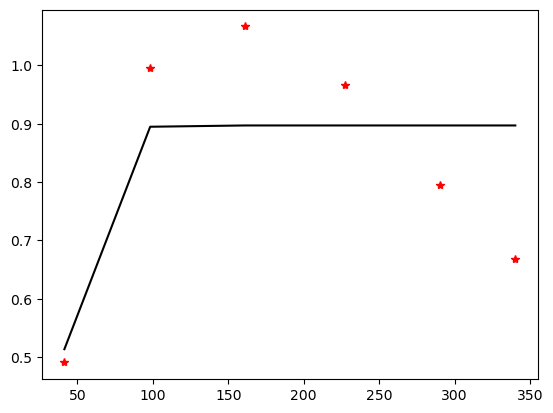

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...

Kriging MSE con 50 punti per striscia: 0.0261


In [12]:
# Kriging vettorializzato e stima errori
# --------------------------------------------------
# seleziono 200 punti da ogni striscia
# Campiona 200 punti casuali da ciascuna striscia di training
df_train_sampled = (
    df_train.groupby('lon_band')
    .apply(lambda g: g.sample(n=200,  random_state=42))
    .reset_index(drop=True))

# Coordinate e valori da usare per il Kriging
lon_tr = df_train_sampled['lon'].values
lat_tr = df_train_sampled['lat'].values
val_tr = df_train_sampled['log_dep_norm'].values

# Inizializza il modello Kriging
ok = OrdinaryKriging(
    lon_tr, lat_tr, val_tr,
    variogram_model='spherical', verbose=True, enable_plotting=True)
# Esegui la predizione
krig_arr, _ = ok.execute(
    'points',
    df_test['lon'].values,
    df_test['lat'].values)
# Calcola MSE

krig_g = krig_arr.reshape(-1, 1)
Yg = df_test['log_dep_norm'].values.reshape(-1, 1)
mse_krig = np.mean((krig_g - Yg) ** 2)
print(f"Kriging MSE con 50 punti per striscia: {mse_krig:.4f}")




In [20]:
with open("functions_plot_calculations.py", 'r') as file:
    content = file.read()

# Execute the content of the .py file
exec(content)


def calculate_save_df(model, df_to_predict, mean, std, path, filename):
    "Perform the predictions and save the results."
    U_pred = model.predict(df_to_predict[['lon', 'lat']].values / 90)
    U_pred_denorm = (U_pred * std) + mean
    df_to_predict['PINN_log_dep'] = U_pred_denorm
    df_to_predict.to_csv(path + filename, index=False)


def calculate_save_kriging_df(ok_model, df_to_predict, path, filename):
    """
    Esegue la predizione con Kriging su df_to_predict e salva il risultato.
    ok_model: oggetto OrdinaryKriging già addestrato
    df_to_predict: DataFrame con colonne 'lon' e 'lat'
    """
    # Esegui predizione (già in scala originale)
    krig_arr, _ = ok_model.execute('points', df_to_predict['lon'].values, df_to_predict['lat'].values)

    # Aggiungi la colonna al DataFrame (senza denormalizzazione!)
    df_to_predict['Kriging_log_dep'] = krig_arr

    # Salva il risultato
    df_to_predict.to_csv(path + filename, index=False)


mean = df_simulated_Holocene['log_dep'].mean()
std = df_simulated_Holocene['log_dep'].std()

calculate_save_df(pinn_model, df_test, mean, std, RESULTS_PATH, "df_pinn_200xbands.csv")
calculate_save_df(pinn_model, df_global_grid_1x1, mean, std, RESULTS_PATH, "df_pinn_200xbands_grid_1x1.csv")
calculate_save_kriging_df(ok, df_test, RESULTS_PATH, "df_kriging_200xbands.csv")



Executing Ordinary Kriging...



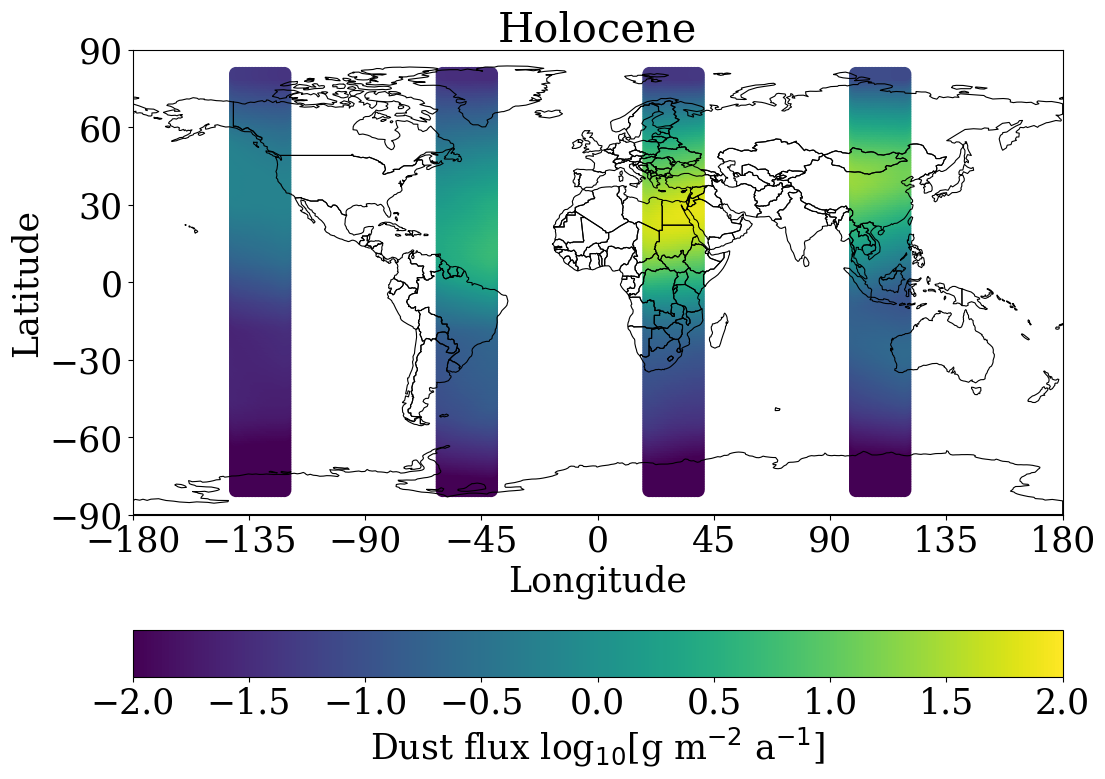

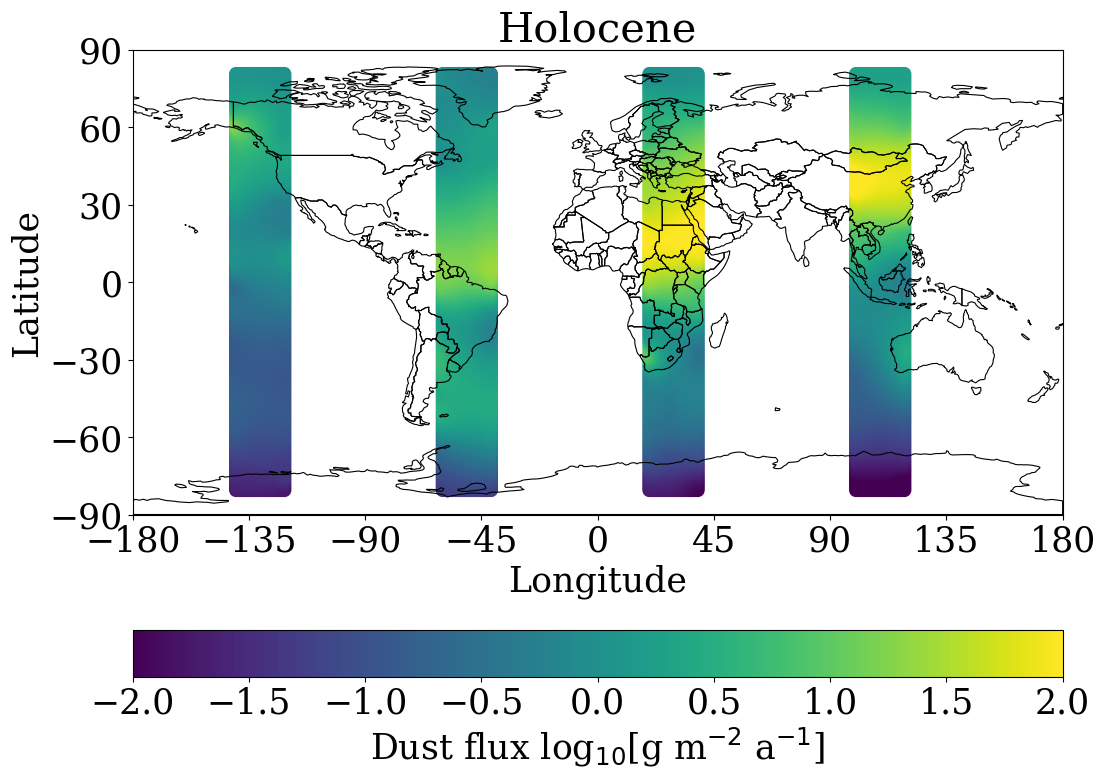

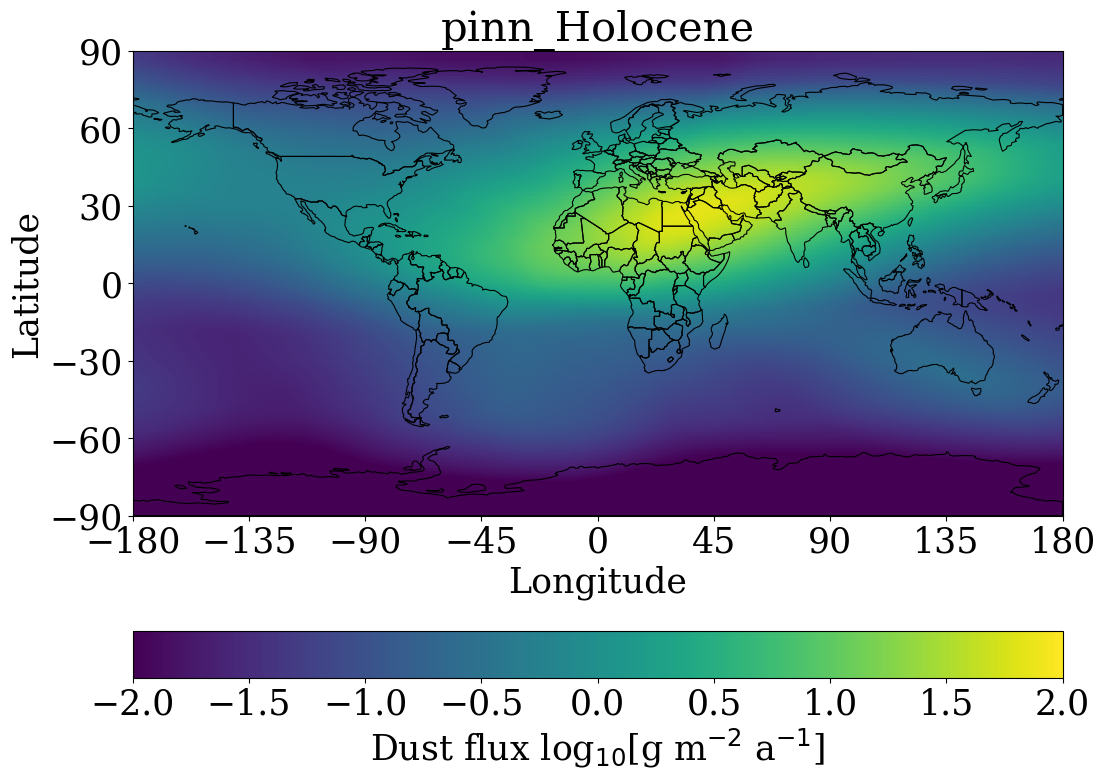

In [21]:
df_pinn_200xbands = pd.read_csv(
    "C:/Users/vitas/Desktop/LE PINN/pinn.global.dust/pinn.global.dust/Data\model_results/df_pinn_200xbands.csv")
df_pinn_200xbands_grid_1x1= pd.read_csv(
    "C:/Users/vitas/Desktop/LE PINN/pinn.global.dust/pinn.global.dust/Data/model_results/df_pinn_200xbands_grid_1x1.csv")
df_kriging_200xbands= pd.read_csv(
    "C:/Users/vitas/Desktop/LE PINN/pinn.global.dust/pinn.global.dust/Data/model_results/df_kriging_200xbands.csv")

plot_dust_deposition_simulated(

    df=df_pinn_200xbands,
    title='Holocene',
    name_to_save='PINN_MAP_200xbands_HOLOCENE',
    figure_save_path=FIGURE_PATH,
    label_str='PINN_log_dep',
    limit_bar=2,

)

plot_dust_deposition_simulated(
    df=df_kriging_200xbands,
    title='Holocene',
    name_to_save='kriging_MAP_200xbands_HOLOCENE',
    figure_save_path=FIGURE_PATH,
    label_str='Kriging_log_dep',
    limit_bar=2,

)
plot_dust_deposition_simulated(
    df=df_pinn_200xbands_grid_1x1,

    title='pinn_Holocene',
    name_to_save='PINN_MAP_200xbands grid1x1_HOLOCENE',
    figure_save_path=FIGURE_PATH,
    label_str='PINN_log_dep',
    limit_bar=2,

)



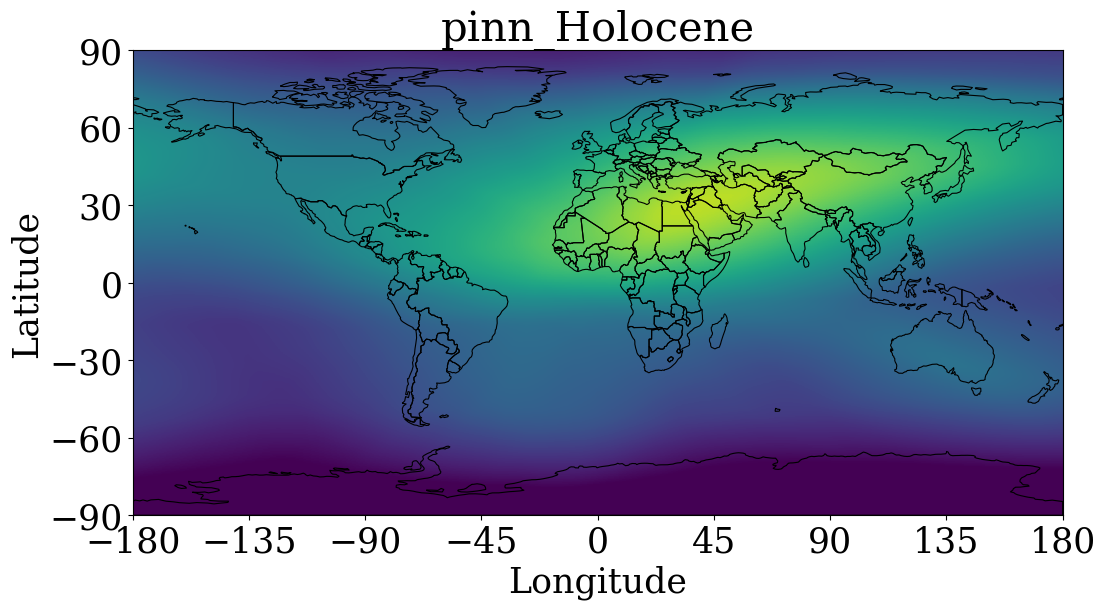

In [24]:
params_plot = {
    'axes.labelsize': 25,
    'axes.titlesize': 30,
    'xtick.labelsize': 25,
    'ytick.labelsize': 25,
    'lines.linewidth': 20,
    'legend.fontsize': 20,
    'font.family': 'DeJavu Serif',
    'font.serif': 'Times New Roman',
}

plt.rcParams.update(params_plot)


def plot_map(df_PINN, title, name_to_save, figure_save_path, label_str='log_dep', measure_units='Dust flux log$_{10}$[g m$^{-2}$ a$^{-1}$]', limit_bar=3.2):
    """
    Generate the matplot of the calculation of the PINN.
    Also, the empirical dataset is included in the plot

    Parameters:
    - df_PINN (pandas DataFrame): The dataframe containing the dust deposition predicted by the PINN.
    - df_empirical (pandas DataFrame): The dataframe containing the dust deposition data.
    - title (str): The title to be displayed on the plot.
    - name_to_save (str): The filename to save the generated map plot.
    - label_str (str): The column name in the dataframe to use for labeling the data on the plot. Defaults to 'log_dep'.
    - figure_save_path (str): The directory path where the plot will be saved.
    - measure_units (str): The units of measurement for the dust flux. Defaults to 'Dust flux log$_{10}$[g m$^{-2}$ a$^{-1}$]'.
    - limit_bar (float,): The limit value for the colorbar on the plot. Defaults to 3.2.
    """

    plt.rcParams.update(params_plot)


    # Create figure
    fig, ax = plt.subplots(figsize=(12, 10))

    # Plot continents
    path_to_shapefile = "C:/Users/vitas/Desktop/LE PINN/pinn.global.dust/pinn.global.dust/ne_110m_admin_0_countries.shp"
    world = gpd.read_file(path_to_shapefile)

    world.boundary.plot(ax=ax, color='black', linewidth=0.8)



    # Plot the prediction after reshaping it
    U_pred_PINNs_reshape = df_PINN['PINN_log_dep'].values.reshape(180, 360)
    h = ax.imshow(U_pred_PINNs_reshape,
                  origin='lower',
                  extent=[-180, 180, -90, 90],
                  cmap='viridis',
                  vmin=-limit_bar,
                  vmax=limit_bar)

    # Set axis-labels, title, limits and ticks
    ax.set(xlabel='Longitude', ylabel='Latitude', title=title)
    ax.set_xlim(-180, 180)
    ax.set_ylim(-90, 90)
    ax.set_xticks(np.arange(-180, 181, 45))
    ax.set_yticks(np.arange(-90, 91, 30))

    # Save and show the plot
    plt.savefig(f"{figure_save_path}/{name_to_save}.pdf", bbox_inches='tight', dpi=600)
    plt.show()




plot_map(
    df_pinn_200xbands_grid_1x1,
   # df_pinn_200xbands,
    title='pinn_Holocene',
    name_to_save='PINN_MAP_200xbands',
    figure_save_path=FIGURE_PATH,
    label_str='PINN_log_dep',
    limit_bar=2.3,

)